In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# !cp -r /content/gdrive/MyDrive/Financial_NLP/raw/ ./raw

In [9]:
# @title Imports
import os
import sys
import datetime
import random
import logging
from datetime import timedelta
from typing import List, Callable
from collections import Counter
from functools import partial
import warnings
from sklearn.metrics import matthews_corrcoef


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup
)
from tqdm.auto import tqdm
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold
from scipy.special import softmax
import torch
from torch import nn
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader, Dataset as torchDS
from functools import partial
import torch
import re
import string
import time

from typing import Optional

# Disable specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="accelerate")
warnings.filterwarnings("ignore", category=FutureWarning, module="huggingface_hub.file_download")
warnings.filterwarnings("ignore", module="sklearn.metrics._classification")
neptune_logger = logging.getLogger('neptune')
neptune_logger.setLevel(logging.ERROR)

In [3]:
# @title Predifined Classes
class Labeler:
    def __init__(self, name):
        """
        Initialize the labeler.

        Args:
        name (str): The name of the labeler.
        """
        self.name = name

    def fit(self, data):
        """
        Fit the labeler to the data.

        This method should be overridden by subclasses to implement
        the actual fitting logic.

        Args:
        data (any): The data to fit the labeler to.
        """
        raise NotImplementedError("Subclasses must implement this method.")

    def transform(self, data):
        """
        Transform the data into labels.

        This method should be overridden by subclasses to implement
        the actual transformation logic.

        Args:
        data (any): The data to transform into labels.

        Returns:
        any: The labels.
        """
        raise NotImplementedError("Subclasses must implement this method.")

class TripleBarrierLabeler(Labeler):
    def __init__(self, volatility_period=7, upper_barrier_factor=1, lower_barrier_factor=1, vertical_barrier=7, min_trend_days=2, barrier_type='volatility', touch_type="HL", up_label=2, neutral_label=1, down_label=0):
        """
        Initialize the labeler.
        """
        super().__init__(name="triple barrier labeling")
        self.volatility_period = volatility_period
        self.upper_barrier_factor = upper_barrier_factor
        self.lower_barrier_factor = lower_barrier_factor
        self.vertical_barrier = vertical_barrier
        self.min_trend_days = min_trend_days
        self.barrier_type = barrier_type
        self.touch_type = touch_type
        self.up_label = up_label
        self.down_label = down_label
        self.neutral_label = neutral_label

    def calculate_barriers(self, df, i, window):
        """calculate the barriers based on either volatility or returns of the backward window

        Args:
            df (pd.DataFrame): Data
            i (pd.index): the index of the beginning of the window
            window (int): window size

        Returns:
            df: Data including barriers for the forward window
        """
        end_window = min(i+window, len(df)-1)  # Ensure the window does not exceed the dataframe

        # Calculate the mean volatility or daily returns over the volatility_period
        if self.barrier_type == 'volatility':
            current_value = df.loc[i, 'volatility']
        elif self.barrier_type == 'returns':
            current_value = df.loc[i, 'daily_returns']
        else:
            raise ValueError("Invalid barrier_type. Choose either 'volatility' or 'returns'")

        df.loc[i:end_window, 'upper_barrier'] = df.loc[i, 'close'] + (df.loc[i, 'close'] * current_value * self.upper_barrier_factor)
        df.loc[i:end_window, 'lower_barrier'] = df.loc[i, 'close'] - (df.loc[i, 'close'] * current_value * self.lower_barrier_factor)
        return df

    def label_observations(self, df, origin, i, label):
        df.loc[origin:i+1, 'label'] = label
        return df

    def get_daily_vol(self, close, span0=100):
        """
        Calculate the daily volatility of closing prices.

        Parameters:
        - close: A pandas Series of closing prices.
        - span0: The span for the EWM standard deviation.

        Returns:
        - A pandas Series of daily volatility estimates.
        """
        # Find the start of the previous day for each day
        prev_day_start = close.index.searchsorted(close.index - pd.Timedelta(days=1))
        prev_day_start = prev_day_start[prev_day_start > 0]

        # Create a series with the start of the previous day for each day
        prev_day_start = pd.Series(close.index[prev_day_start - 1], index=close.index[close.shape[0] - prev_day_start.shape[0]:])

        # Calculate daily returns
        daily_returns = close.loc[prev_day_start.index] / close.loc[prev_day_start.values].values - 1

        # Calculate EWM standard deviation of daily returns
        daily_vol = daily_returns.ewm(span=span0).std()

        return daily_returns, daily_vol

    def fit(self, sdf):
        df = sdf.copy()
        # Calculate daily returns and volatility
        df['daily_returns'], df['volatility'] = self.get_daily_vol(df.close, self.volatility_period)

        df = df.reset_index()
        # Initialize label and window start
        df['label'] = self.neutral_label
        df['window_start'] = False

        self.data = df

    def transform(self):
        """
        Transform the data into labels.

        Returns:
        pd.DataFrame: The labels.
        """
        window = self.vertical_barrier
        origin = 0
        touch_upper = lambda high, barrier: high >= barrier
        touch_lower = lambda low, barrier: low <= barrier
        # For each observation
        for i in range(0, len(self.data)):
            # Define your barriers at the beginning of each window
            if i == origin:
                self.data = self.calculate_barriers(self.data, i, window)
                self.data.loc[i, 'window_start'] = True  # Mark the start of the window

            # one of the conditions were met
            if touch_upper(self.data.loc[i, "high" if self.touch_type == 'HL' else 'close'], self.data.loc[i, "upper_barrier"]):
                if (i - origin > self.min_trend_days):
                    # label the observations
                    self.data = self.label_observations(self.data, origin, i, self.up_label)
                    # set new origin
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index
                    # reset window
                    window = self.vertical_barrier
            elif touch_lower(self.data.loc[i, "low" if self.touch_type == 'HL' else 'close'], self.data.loc[i, "lower_barrier"]):
                if (i - origin > self.min_trend_days):
                    # label the observations
                    self.data = self.label_observations(self.data, origin, i, self.down_label)
                    # set new origin
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index
                    # reset window
                    window = self.vertical_barrier

            # none of the conditions were met
            else:
                if window > 0:
                    # reduce window size by one
                    window = window - 1
                else:
                    # reset window
                    window = self.vertical_barrier
                    # label neutral from origin to origin + window
                    self.data.loc[origin:min(origin+window, len(self.data)-1), 'label'] = self.neutral_label  # Ensure the window does not exceed the dataframe
                    # set origin to the next id
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index

        self.data = self.data.set_index("timestamp")
        return self.data

def optimize_parameters(price_df, param_grid, initial_capital=100000, num_starts=10, optimization_interval='6M'):
    """
    Optimize the parameters every six months or use the whole dataset if no interval is provided.

    Parameters:
    - price_df: DataFrame containing price data.
    - param_grid: Dictionary containing parameter ranges.
    - initial_capital: Starting capital for the simulation.
    - num_starts: Number of random starts for the optimization.
    - optimization_interval: Interval for re-optimization (default is '6M').

    Returns:
    - DataFrame with optimized parameters for each interval or the whole dataset.
    """
    if optimization_interval is None:
        # Use the whole dataset for optimization
        best_params, best_sharpe_ratio, best_net_profit = tune_hyperparameters_scipy(price_df, param_grid, initial_capital, num_starts)
        return pd.DataFrame([{
            'start': price_df.index[0],
            'end': price_df.index[-1],
            'params': best_params,
            'sharpe_ratio': best_sharpe_ratio,
            'net_profit': best_net_profit
        }])
    else:
        # Optimize parameters at specified intervals
        intervals = pd.date_range(start=price_df.index[0], end=price_df.index[-1], freq=optimization_interval)
        optimized_params = []

        for start, end in zip(intervals[:-1], intervals[1:]):
            interval_df = price_df.loc[start:end]
            best_params, best_sharpe_ratio, best_net_profit = tune_hyperparameters_scipy(interval_df, param_grid, initial_capital, num_starts)
            optimized_params.append({
                'start': start,
                'end': end,
                'params': best_params,
                'sharpe_ratio': best_sharpe_ratio,
                'net_profit': best_net_profit
            })

        return pd.DataFrame(optimized_params)

def get_daily_vol(close, span0=100):
    """
    Calculate the daily volatility of closing prices.

    Parameters:
    - close: A pandas Series of closing prices.
    - span0: The span for the EWM standard deviation.

    Returns:
    - A pandas Series of daily volatility estimates.
    """
    # Find the start of the previous day for each day
    prev_day_start = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    prev_day_start = prev_day_start[prev_day_start > 0]

    # Create a series with the start of the previous day for each day
    prev_day_start = pd.Series(close.index[prev_day_start - 1], index=close.index[close.shape[0] - prev_day_start.shape[0]:])

    # Calculate daily returns
    daily_returns = close.loc[prev_day_start.index] / close.loc[prev_day_start.values].values - 1

    # Calculate EWM standard deviation of daily returns
    daily_vol = daily_returns.ewm(span=span0).std()

    return daily_returns, daily_vol

def get_t_events(raw_price, volatility, base_threshold):
    """
    :param raw_price: (series) of close prices.
    :param volatility: (series) of volatility values.
    :param base_threshold: (float) base level for the threshold.
    :return: (datetime index vector) vector of datetimes when the events occurred. This is used later to sample.
    """
    print('Applying Symmetric CUSUM filter.')

    t_events, s_pos, s_neg = [], 0, 0

    # log returns
    diff = np.log(raw_price).diff().dropna()

    # Get event time stamps for the entire series
    for i in tqdm(diff.index[1:]):
        # Adjust the threshold based on volatility
        threshold = base_threshold * volatility.loc[i]

        s_pos = max(0.0, float(s_pos + diff.loc[i]))
        s_neg = min(0.0, float(s_neg + diff.loc[i]))

        if s_neg < -threshold:
            s_neg = 0
            t_events.append(i)

        elif s_pos > threshold:
            s_pos = 0
            t_events.append(i)

    event_timestamps = pd.DatetimeIndex(t_events)
    return event_timestamps

def plot_close_and_events(price_df, event_columns):
    # Create a new figure and set the size
    plt.figure(figsize=(14, 7))

    # Plot the close price
    plt.plot(price_df.index, price_df['close'], label='Close Price')

    # Define a list of colors for the events
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    # Plot each event column with a different color
    for i, event_column in enumerate(event_columns):
        event_indices = price_df[price_df[event_column] == True].index
        event_values = price_df.loc[event_indices, 'close']
        plt.scatter(event_indices, event_values, color=colors[i % len(colors)], label=event_column)

    # Set the title and labels
    plt.title('Close Price and Events')
    plt.xlabel('Date')
    plt.ylabel('Close Price')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

def label_sentiment_events(df, window, upper_barrier_coef=0.5, lower_barrier_coef=0.5):
    # Calculate the rolling standard deviation for the ratio
    rolling_std = df['ratio'].rolling(window=window).std()

    # Calculate the mean sentiment ratio
    mean_sentiment = df['ratio'].rolling(window=window).mean()

    # Define the thresholds for labeling
    upper_threshold = mean_sentiment + upper_barrier_coef * rolling_std
    lower_threshold = mean_sentiment - lower_barrier_coef * rolling_std

    # Initialize the labels
    labels = pd.Series(index=df.index, dtype='object')

    # Label each day based on the sentiment ratios
    for date in df.index:
        if df.loc[date, 'ratio'] > upper_threshold.loc[date]:
            labels[date] = 'bullish'
        elif df.loc[date, 'ratio'] < lower_threshold.loc[date]:
            labels[date] = 'bearish'
        else:
            labels[date] = 'neutral'

    return labels

def calc_daily_ratios(text_df, column="sentiment_label"):
    grouped_df = text_df.groupby(['date', column]).size().unstack(fill_value=0)
    # Calculate the ratio of label 2 to label 1
    grouped_df['ratio'] = grouped_df[2] / grouped_df[1] + grouped_df[0]
    # Replace inf values with NaN (in case there are days without label 1)
    grouped_df['ratio'].replace(float('inf'), pd.NA, inplace=True)
    grouped_df.rename(columns={0: "bearish", 1 : "neutral", 2: "bullish"}, inplace=True)
    return grouped_df

def get_daily_average(df, column="impact_label"):
    # Group by the date index and calculate the mean for each impact_label
    result = df.groupby(['date', column]).mean()
    
    return result

def pandas_data_loader(addr: str, columns: List[str], *transforms: Callable[[pd.DataFrame], pd.DataFrame]) -> pd.DataFrame:
    # Load the data from the CSV file
    df = pd.read_csv(addr, usecols=columns)

    # Apply each transform to the DataFrame
    for transform in transforms:
        df = transform(df)

    return df

# Transform index to datetime
def index_to_datetime(df, unit="s"):
    df.index = pd.to_datetime(df.index, unit=unit)
    return df
# Transform col to index
to_index = lambda col, df: df.set_index(col)
# Rename text_plit to text
rename = lambda original, new, df: df.rename(columns={original: new})

In [4]:
# @title load price data
address = "../raw/daily-2020.csv" # @param {"type":"string","placeholder":"./raw/daily-2020.csv"}
# Loading the price data
columns = ["timestamp", "close", "open", "high", "low", "volume"]
price_df = pandas_data_loader(address, columns, partial(to_index, "timestamp"), index_to_datetime)

In [5]:
# @title load text data
sentiment = True # @param {"type":"boolean","placeholder":"True"}
address = "../raw/labeled_tweets.csv" # @param {"type":"string","placeholder":"./raw/labeled_tweets.csv"}
columns = ["text", "sentiment_label", "date"]
text_df = pandas_data_loader(address, columns, partial(to_index, "date"), partial(index_to_datetime, unit='ns'), partial(rename, "text_split", "text"))
text_df = text_df["2020-01-01":"2021-01-01"]

In [4]:
# @title load text data
address = "../raw/impact_labeled.csv" # @param {"type":"string","placeholder":"./raw/labeled_tweets.csv"}
columns = ["text", "impact_label", "date"]
impact_df = pandas_data_loader(address, columns, partial(to_index, "date"), partial(index_to_datetime, unit='ns'), partial(rename, "text_split", "text"))
# impact_df = impact_df["2020-01-01":"2021-01-01"]

In [7]:
# @title load events
sentiment = True # @param {"type":"boolean","placeholder":"True"}
address = "../raw/bitcoin_events.csv" # @param {"type":"string","placeholder":"./raw/labeled_tweets.csv"}
columns = ["title", "date"]
event_df = pandas_data_loader(address, columns, partial(to_index, "date"), partial(index_to_datetime, unit='ns'), partial(rename, "text_split", "text"))
event_df = event_df.sort_index()
event_df = event_df.iloc[141:179]

In [5]:
event_df.shape

NameError: name 'event_df' is not defined

## Event Extraction

In [45]:
price_df["daily_returns"], price_df["volatility"] = get_daily_vol(price_df.close)
price_df.dropna(inplace=True)
events = get_t_events(price_df.close, price_df.volatility, 2)
price_df["volatility_event"] = price_df.index.isin(events)
price_df.volatility_event.value_counts()

Applying Symmetric CUSUM filter.


  0%|          | 0/361 [00:00<?, ?it/s]

volatility_event
False    326
True      37
Name: count, dtype: int64

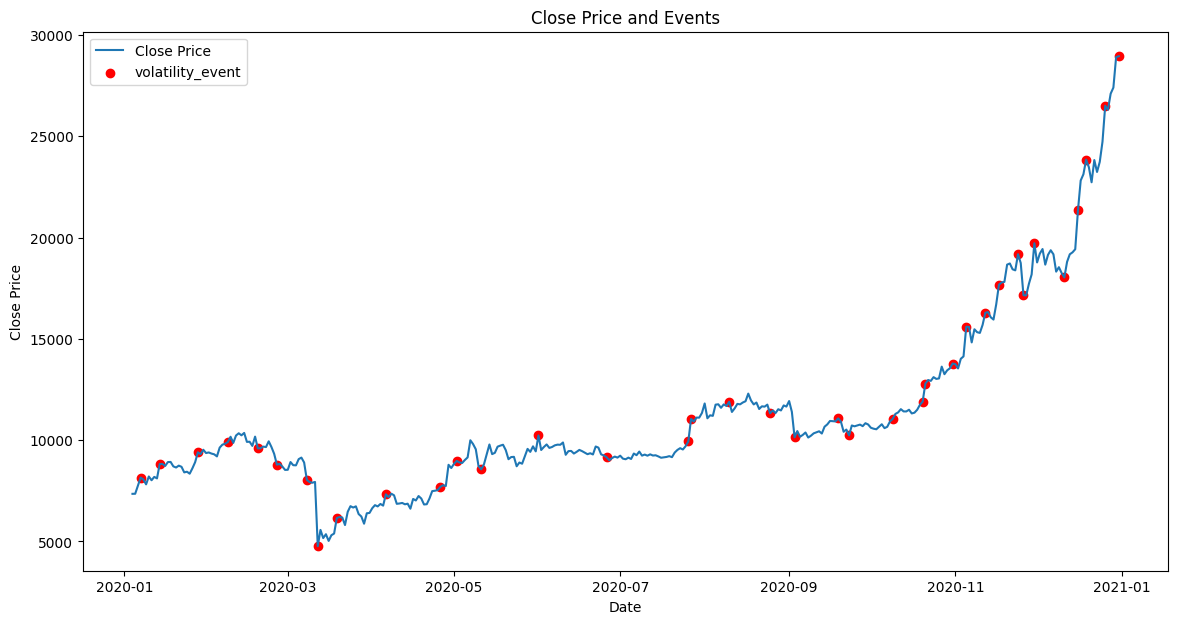

In [46]:
# Call the function with your DataFrame
plot_close_and_events(price_df, ["volatility_event"])

In [47]:
ratio_df = calc_daily_ratios(text_df)

In [48]:
merge_df = price_df.merge(ratio_df, how="left", left_index=True, right_index=True)

In [49]:
merge_df

,open,high,low,close,volume,daily_returns,volatility,volatility_event,bearish,neutral,bullish,ratio
timestamp,,,,,,,,,,,,
2020-01-04,7341.60,7400.00,7269.21,7350.71,92586.033,0.055827,0.025314,False,0,52,121,2.326923
2020-01-05,7350.54,7495.00,7303.00,7354.36,117765.972,0.001722,0.027620,False,0,71,114,1.605634
2020-01-06,7354.36,7808.65,7345.00,7757.39,168150.317,0.055325,0.026958,False,0,73,109,1.493151
2020-01-07,7757.74,8215.33,7733.00,8152.49,280809.162,0.108525,0.041275,True,0,49,110,2.244898
2020-01-08,8150.90,8468.42,7870.11,8059.84,321225.114,0.038989,0.036967,False,0,46,111,2.413043
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,26508.84,28459.84,25850.00,26305.64,540264.148,0.063714,0.048716,False,0,107,151,1.411215
2020-12-28,26301.76,27538.82,26117.10,27102.66,267563.468,0.022401,0.048231,False,0,100,149,1.490000
2020-12-29,27101.45,27441.73,25913.01,27402.83,260759.449,0.041709,0.047837,False,1,93,148,2.591398


In [83]:
merge_df["sentiment_event"] = label_sentiment_events(merge_df, 7, 1, 1)
merge_df["neutral_sentiment_event"] = merge_df["sentiment_event"] == "neutral"
merge_df["bullish_sentiment_event"] = merge_df["sentiment_event"] == "bullish"
merge_df["bearish_sentiment_event"] = merge_df["sentiment_event"] == "bearish"
merge_df.sentiment_event.value_counts()

sentiment_event
neutral    242
bullish     63
bearish     58
Name: count, dtype: int64

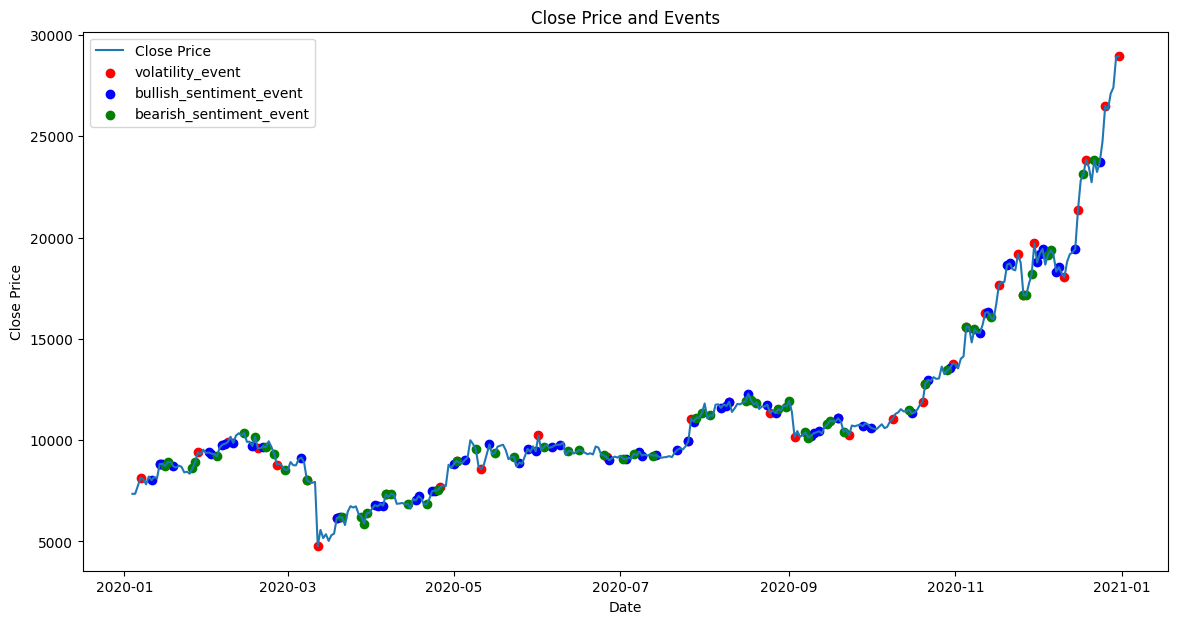

In [84]:
plot_close_and_events(merge_df, ["volatility_event", "bullish_sentiment_event", "bearish_sentiment_event"])

In [85]:
final_df = merge_df.merge(event_df, how="left", left_index=True, right_index=True)
final_df.title.fillna(False, inplace=True)
final_df["actual_event"] = final_df["title"] != False

In [86]:
events = final_df[["actual_event", "neutral_sentiment_event", "bullish_sentiment_event", "bearish_sentiment_event", "volatility_event"]]

In [87]:
# Filter the neutral events where there are no actual events
filtered_events = events[(events["neutral_sentiment_event"] == True) & (events["actual_event"] == False)]

In [88]:
events.actual_event.value_counts()

actual_event
False    325
True      38
Name: count, dtype: int64

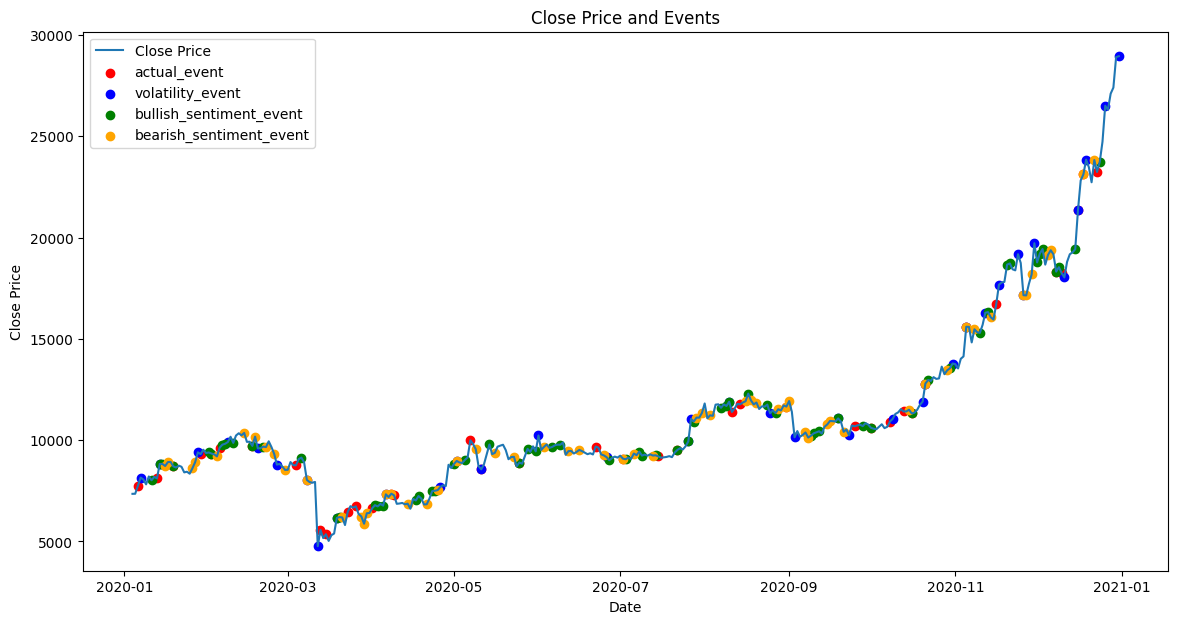

In [89]:
plot_close_and_events(final_df, ["actual_event", "volatility_event", "bullish_sentiment_event", "bearish_sentiment_event"])

In [90]:
final_df["non_neutral_sentiment_event"] = (final_df["bullish_sentiment_event"]) | (final_df["bearish_sentiment_event"])

In [91]:
final_df.non_neutral_sentiment_event.value_counts()

non_neutral_sentiment_event
False    242
True     121
Name: count, dtype: int64

In [92]:
mcc = matthews_corrcoef(final_df['actual_event'], final_df['non_neutral_sentiment_event'])

print(f"Matthews Correlation Coefficient: {mcc}")

Matthews Correlation Coefficient: 0.02545139051903111


In [10]:
# Function to get the majority vote
def majority_vote(labels):
    count = Counter(labels)
    return count.most_common(1)[0][0]

# Group by date and apply the majority vote function
result = impact_df.groupby(impact_df.index).impact_label.apply(majority_vote)

In [12]:
result.value_counts()

impact_label
1    1092
2     545
0     467
Name: count, dtype: int64

In [15]:
result.to_csv("../raw/impact_majority.csv")